<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DBSCAN Practice

_Authors: Joseph Nelson (DC)_

---

Now that you're familiar with how DBSCAN works, let's practice it in scikit-learn.

We'll start out working with the [NHL data](https://github.com/josephnelson93/GA-DSI/blob/master/NHL_Data_GA.csv). We're going to investigate clustering teams based on their counting stats.

Use [this glossary of hockey terms](http://stats.hockeyanalysis.com/glossary.php) as a reference guide for what the columns indicate.

In [1]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1) Load our data and perform any basic cleaning and/or exploratory data analysis (EDA).

In [179]:
nhl = pd.read_csv('./datasets/nhl.csv')

In [180]:
nhl.head()

,Team,PTS,Rank,TOI,GF,GA,GF60,GA60,GF%,SF,...,FF%,CF,CA,CF60,CA60,CF%,Sh%,Sv%,PDO,PIM
0,Washington10,121,1,2001:52:00,115,73,3.45,2.19,61.2,1112,...,51.3,2138,1935,64.1,58.0,52.5,10.34,93.03,1034,1269
1,Vancouver11,117,1,2056:14:00,94,72,2.74,2.10,56.6,1143,...,53.1,2144,1870,62.6,54.6,53.4,8.22,93.16,1014,985
2,San Jose10,113,1,1929:54:00,90,68,2.80,2.11,57.0,1065,...,50.9,1985,1876,61.7,58.3,51.4,8.45,93.46,1019,1195
3,Chicago10,112,1,2020:23:00,104,83,3.09,2.46,55.6,1186,...,58.1,2093,1572,62.2,46.7,57.1,8.77,90.44,992,966
4,Vancouver12,111,1,2052:02:00,86,74,2.51,2.16,53.8,1078,...,51.0,2085,1880,61.0,55.0,52.6,7.98,93.36,1013,1049


In [266]:
nhl['TOI2'] = pd.to_timedelta(nhl['TOI'])

In [267]:
nhl['TOI2'][0].seconds

35520L

In [268]:
nhl['day'] = nhl['TOI2'].map(lambda x: x.days)

In [269]:
nhl.head()

,Team,PTS,Rank,TOI,GF,GA,GF60,GA60,GF%,SF,...,CA,CF60,CA60,CF%,Sh%,Sv%,PDO,PIM,TOI2,day
0,Washington10,121,1,2001:52:00,115,73,3.45,2.19,61.2,1112,...,1935,64.1,58.0,52.5,10.34,93.03,1034,1269,83 days 09:52:00,83
1,Vancouver11,117,1,2056:14:00,94,72,2.74,2.10,56.6,1143,...,1870,62.6,54.6,53.4,8.22,93.16,1014,985,85 days 16:14:00,85
2,San Jose10,113,1,1929:54:00,90,68,2.80,2.11,57.0,1065,...,1876,61.7,58.3,51.4,8.45,93.46,1019,1195,80 days 09:54:00,80
3,Chicago10,112,1,2020:23:00,104,83,3.09,2.46,55.6,1186,...,1572,62.2,46.7,57.1,8.77,90.44,992,966,84 days 04:23:00,84
4,Vancouver12,111,1,2052:02:00,86,74,2.51,2.16,53.8,1078,...,1880,61.0,55.0,52.6,7.98,93.36,1013,1049,85 days 12:02:00,85


### 2) Set up an `X` matrix to perform clustering with DBSCAN.

Let's cluster on all features except `team` and `rank`.

Make `rank` our `y` vector, which we can use to perform cluster validation. 

In [270]:
X = nhl.drop(['Team','Rank','TOI','TOI2'], axis=1)

In [271]:
y = nhl['Rank']

### 3) Scatterplot EDA.

Create two scatterplots. At least one axis in one of the plots should represent points (goals for and goals against). Do the scatterplots give us a general idea of how many clusters we should expect to extract with a clustering algorithm?

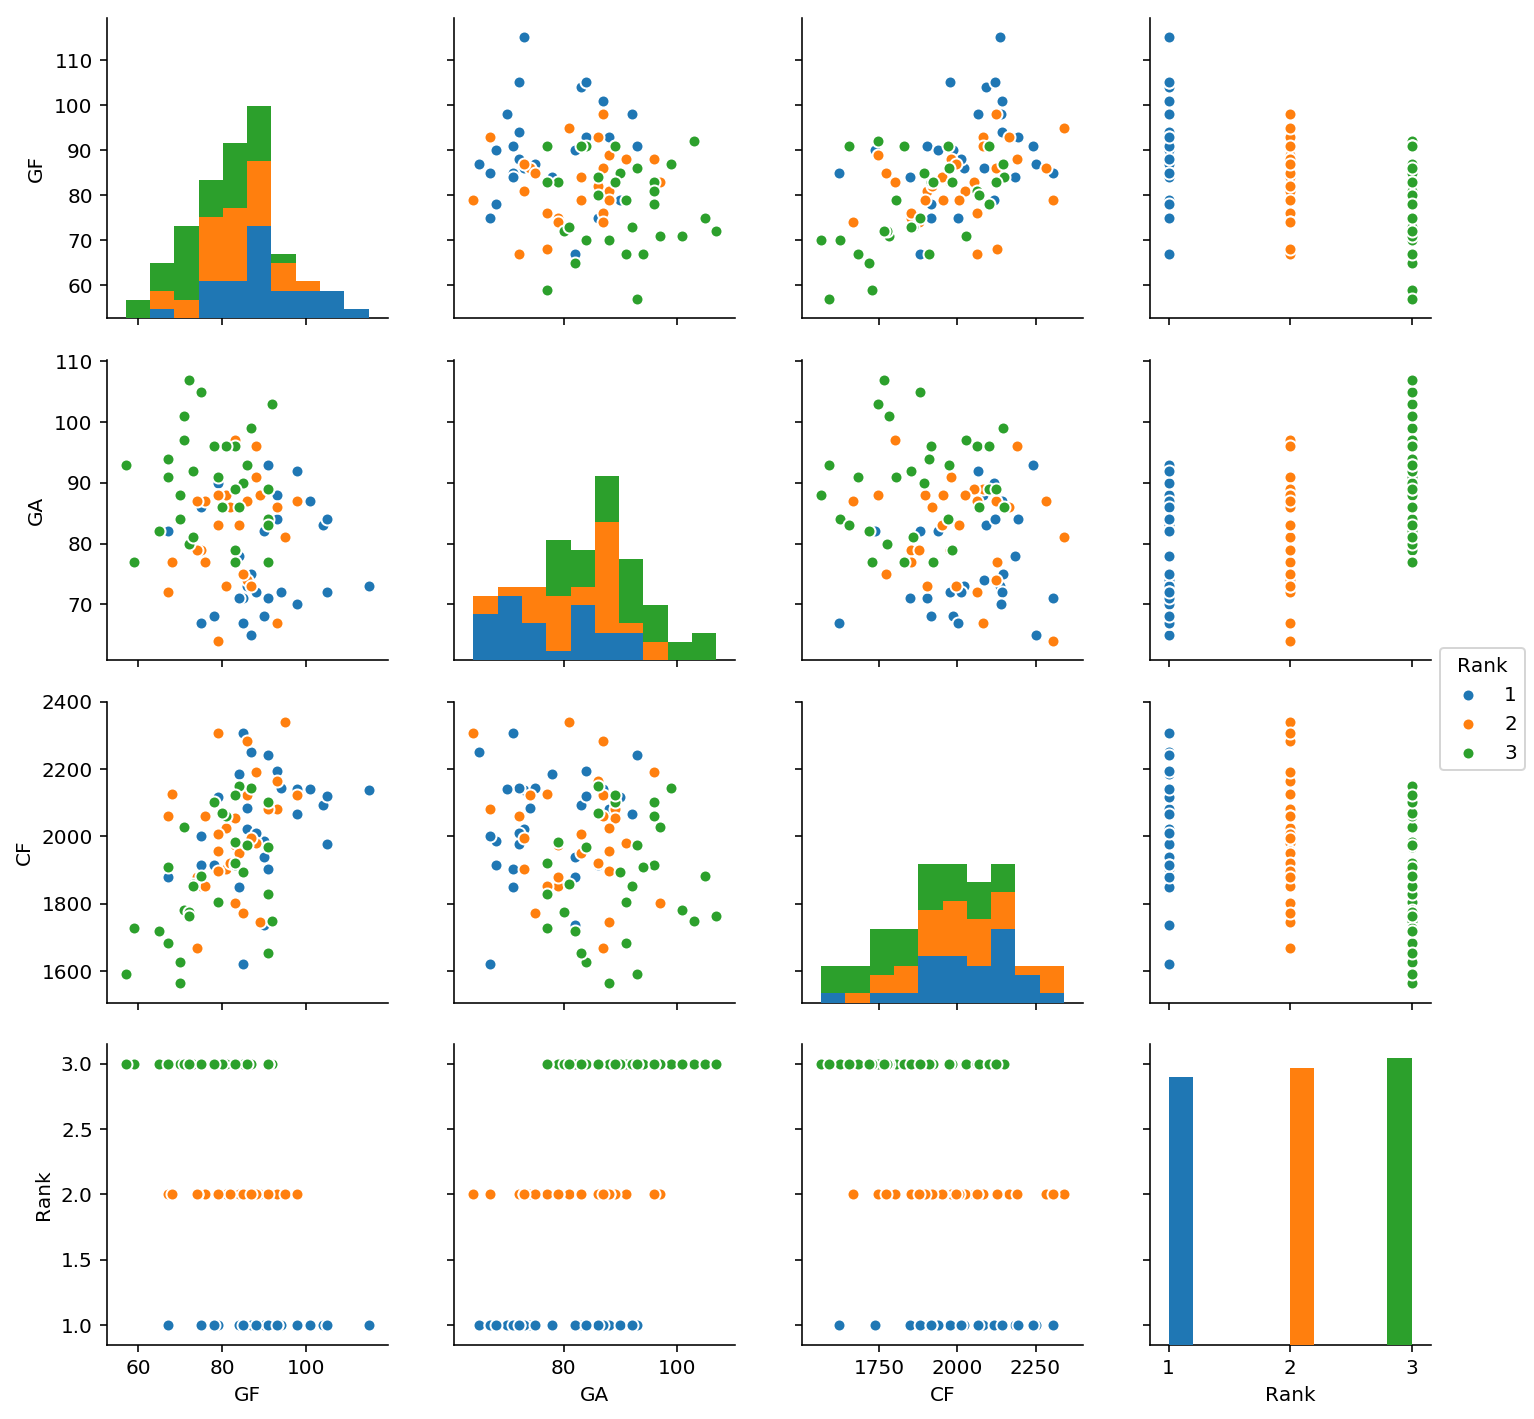

In [187]:
import seaborn as sns
sns.pairplot(nhl[['GF','GA','CF','Rank']], hue='Rank')

### 4) Scale our data.

Standardize the data and compare at least one of the scatterplots for the scaled data to the unscaled data above.

In [272]:
from sklearn.preprocessing import StandardScaler
Xs = StandardScaler().fit_transform(X)
Xs = pd.DataFrame(Xs, columns = X.columns.values)

In [273]:
Xs.head()

,PTS,GF,GA,GF60,GA60,GF%,SF,SA,SF60,SA60,...,CF,CA,CF60,CA60,CF%,Sh%,Sv%,PDO,PIM,day
0,2.330290,3.073219,-1.067259,3.115059,-0.814689,2.429025,0.457748,-0.284091,0.920279,0.051603,...,0.937591,-0.250940,1.551736,0.047130,0.893692,2.929367,0.917697,2.782257,1.570301,-0.427638
1,2.009116,1.038046,-1.170989,0.920436,-1.103358,1.433070,0.782714,-0.204190,0.965219,-0.283549,...,0.971782,-0.674973,1.186016,-0.749646,1.211885,0.470292,1.058474,1.146170,-0.033699,0.012218
2,1.687943,0.650394,-1.585906,1.105897,-1.071283,1.519674,-0.034943,-0.390625,0.830398,0.482512,...,0.065723,-0.635831,0.966584,0.117433,0.504788,0.737078,1.383343,1.555192,1.152357,-1.087422
3,1.607650,2.007176,-0.029966,2.002292,0.051319,1.216557,1.233473,-2.667788,1.774146,-2.629612,...,0.681159,-2.618998,1.088491,-2.600977,2.520014,1.108259,-1.887012,-0.653526,-0.141009,-0.207710
4,1.527357,0.262742,-0.963530,0.209502,-0.910912,0.826836,0.101333,0.621448,0.111352,0.626149,...,0.635571,-0.609737,0.795915,-0.655908,0.929046,0.191906,1.275053,1.064366,0.327766,0.012218


### 5) Fit a DBSCAN clusterer.

Remember to pass an `eps` and `min_samples` of your choice.

In [274]:
len(Xs)

90

In [283]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.7, min_samples=4).fit(Xs)

In [287]:
nhl['predicted'] = db.labels_

### 6) Check out the assigned cluster labels.

Use the `.labels_` command on our DBSCAN class.

In [228]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=4, min_samples=1).fit(Xs)

In [229]:
db.labels_

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

### 7) Evaluate the DBSCAN clusters.

**7.A) Check the silhouette score.**

How are the clusters?

If you're up for a challenge, see how you can adjust our `eps` and `min_points` to improve them.

In [230]:
from sklearn.metrics import silhouette_score
silhouette_score(Xs, db.labels_, metric='euclidean')

0.005425142096420185

**7.B) Check the homogeneity, completeness, and v measure against the stored rank `y`.**

In [139]:
import scipy.stats as stats
y_dict = {}
for r in X['Rank'].unique():
   mode = int(stats.mode(X[X['Rank'] == r]['predicted'])[0])
   y_dict[r] = mode
y_dict

{1: -1, 2: 1, 3: -1}

### 8) Plot the clusters.

You can choose any two variables for the axes.

In [11]:
# A:

### 9) Fit DBSCAN on an easier data set.

Import the `make_circles()` function from `sklearn.datasets`. You can use this to create some fake clusters that will perform well with DBSCAN.

Create some `X` and `y` using the function. Here is some sample code:
```python
from sklearn.datasets import make_circles
circles_X, circles_y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
```

**9.A) Plot the fake circles data.**

In [214]:
from sklearn.datasets import make_circles
circles_X, circles_y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

In [235]:
df = pd.DataFrame(circles_X)
df['y'] = circles_y

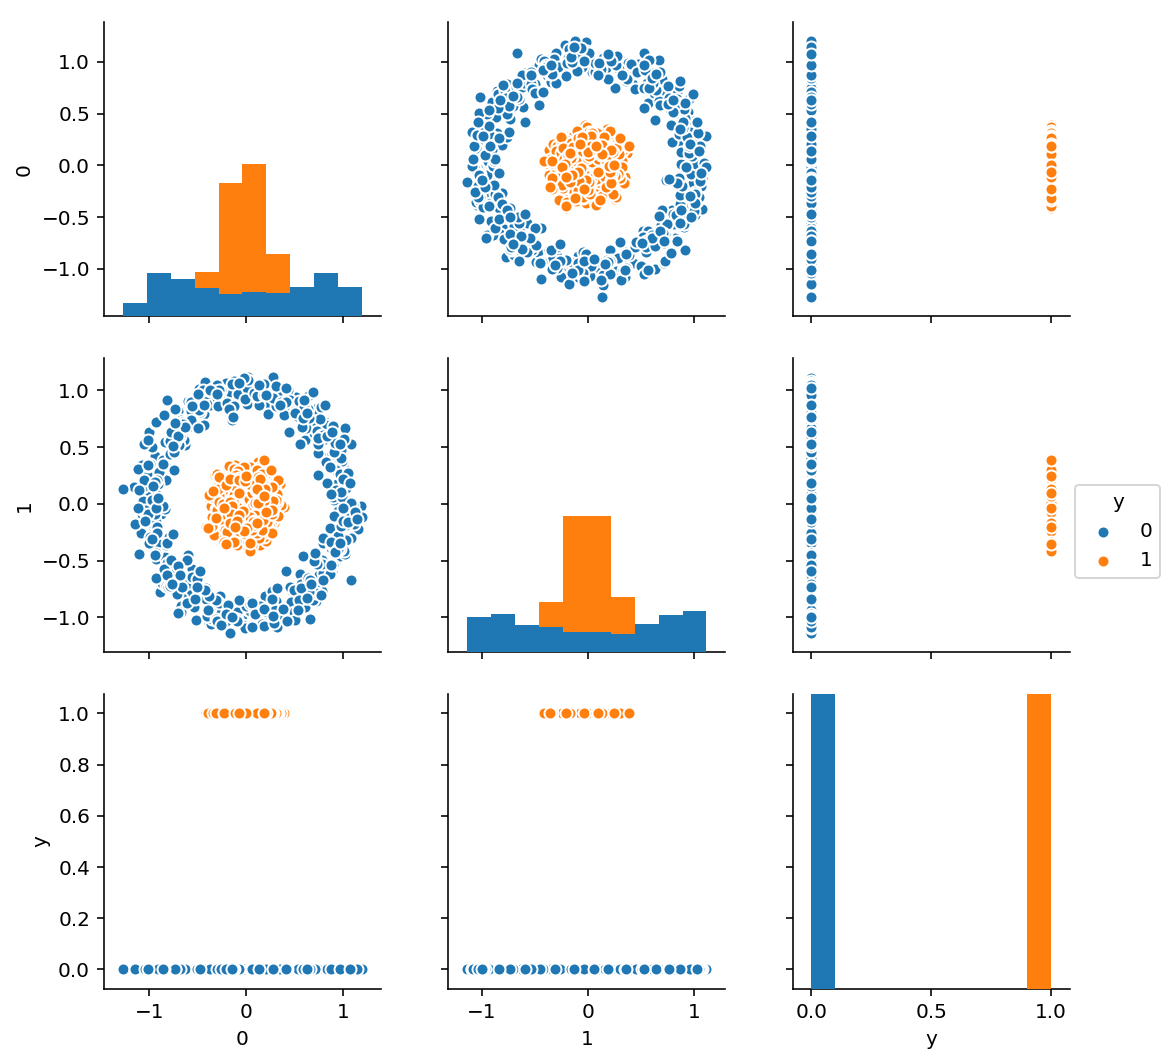

In [236]:
sns.pairplot(df, hue='y')

**9.B) Scale the data and fit DBSCAN on it.**

In [237]:
X = df.drop('y',axis=1)
Xs = StandardScaler().fit_transform(X)
Xs = pd.DataFrame(Xs, columns = X.columns.values)

In [244]:
db = DBSCAN(eps=0.5, min_samples=5).fit(Xs)

In [247]:
predicted = db.labels_

**9.C) Evaluate DBSCAN visually with silhouette and the metrics against the true `y`.**

In [246]:
'''..../)/)
   ...(^.^) hi from the cute bunny!
   ..O(")(")'''

'..../)/)\n   ...(^.^) hi from the cute bunny!\n   ..O(")(")'

In [248]:
Xs['predicted'] = predicted

In [290]:
Xs.head()

,PTS,GF,GA,GF60,GA60,GF%,SF,SA,SF60,SA60,...,CF,CA,CF60,CA60,CF%,Sh%,Sv%,PDO,PIM,day
0,2.330290,3.073219,-1.067259,3.115059,-0.814689,2.429025,0.457748,-0.284091,0.920279,0.051603,...,0.937591,-0.250940,1.551736,0.047130,0.893692,2.929367,0.917697,2.782257,1.570301,-0.427638
1,2.009116,1.038046,-1.170989,0.920436,-1.103358,1.433070,0.782714,-0.204190,0.965219,-0.283549,...,0.971782,-0.674973,1.186016,-0.749646,1.211885,0.470292,1.058474,1.146170,-0.033699,0.012218
2,1.687943,0.650394,-1.585906,1.105897,-1.071283,1.519674,-0.034943,-0.390625,0.830398,0.482512,...,0.065723,-0.635831,0.966584,0.117433,0.504788,0.737078,1.383343,1.555192,1.152357,-1.087422
3,1.607650,2.007176,-0.029966,2.002292,0.051319,1.216557,1.233473,-2.667788,1.774146,-2.629612,...,0.681159,-2.618998,1.088491,-2.600977,2.520014,1.108259,-1.887012,-0.653526,-0.141009,-0.207710
4,1.527357,0.262742,-0.963530,0.209502,-0.910912,0.826836,0.101333,0.621448,0.111352,0.626149,...,0.635571,-0.609737,0.795915,-0.655908,0.929046,0.191906,1.275053,1.064366,0.327766,0.012218


In [250]:
silhouette_score(Xs.drop('predicted', axis=1), db.labels_, metric='euclidean')

0.23783520183694895

In [252]:
df['predicted'] = predicted

In [253]:
from sklearn.metrics import completeness_score
print completeness_score(df['y'], df['predicted'])
from sklearn.metrics import homogeneity_score
print homogeneity_score(df['y'], df['predicted'])
from sklearn.metrics import v_measure_score
print v_measure_score(df['y'], df['predicted'])
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
print(mutual_info_score(df['y'], df['predicted']))
print(adjusted_mutual_info_score(df['y'], df['predicted']))

1.0
1.0
1.0
0.6931471805599454
1.0


In [265]:
import numpy as np
from sklearn.metrics import confusion_matrix
conmat = np.array(confusion_matrix(df['y'], df['predicted'], labels=list(df['predicted'].unique())))
confusion = pd.DataFrame(conmat, index=list(df['y'].unique()),
                         columns=['predicted_' + x for x in list(df['predicted'].unique().astype('str'))])
confusion

,predicted_0,predicted_1
0,500,0
1,0,500


In [263]:
['predicted_' + x for x in list(df['predicted'].unique().astype('str'))]

['predicted_0', 'predicted_1']

In [262]:
df['predicted'].unique().astype('str')

array(['0', '1'], dtype='|S21')

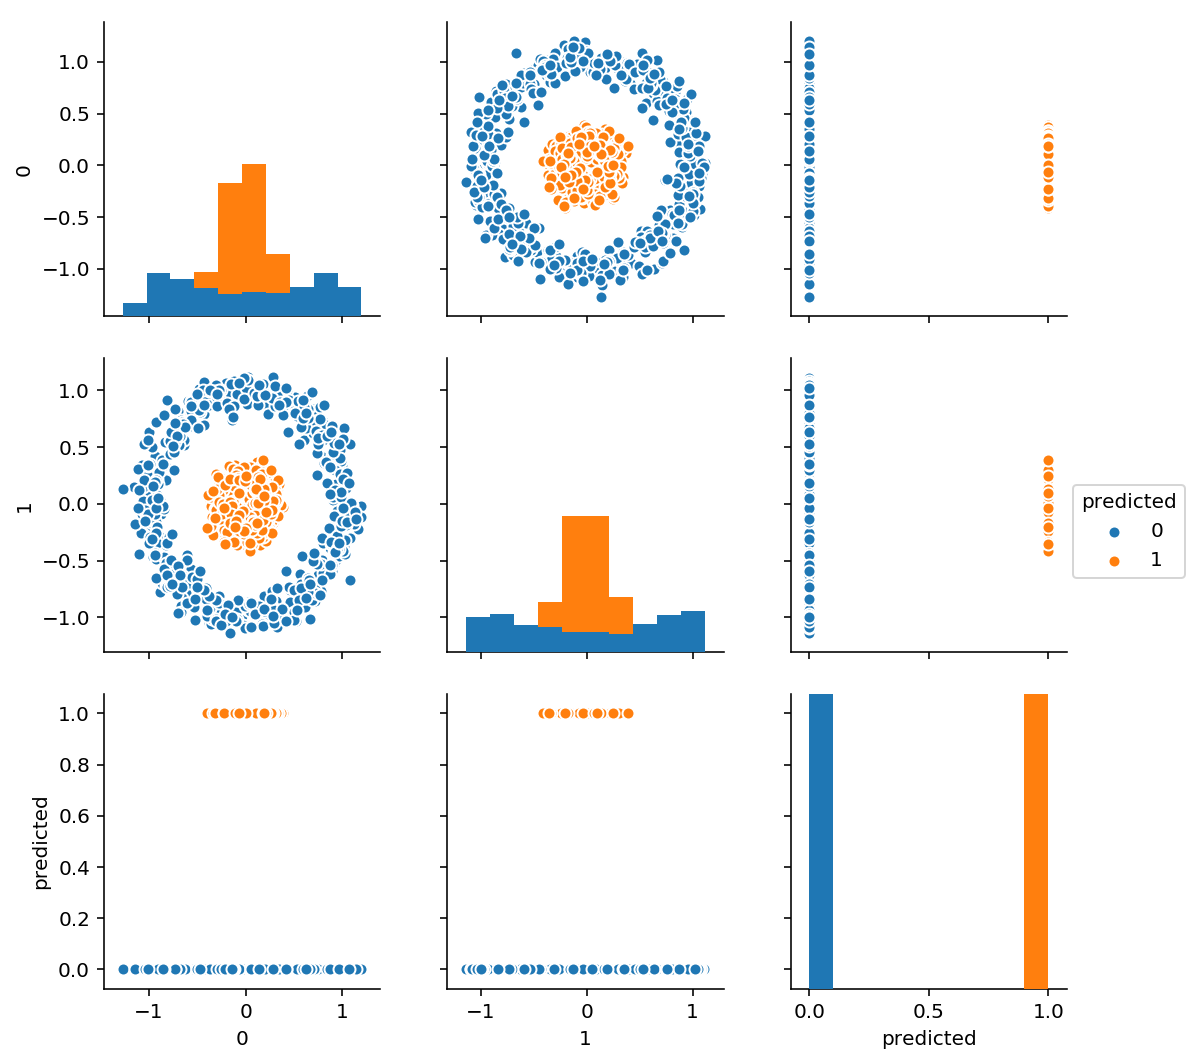

In [289]:
sns.pairplot(df.drop('y', axis=1), hue='predicted')